In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import seaborn as sns
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv("raw sales nt.csv", index_col='date',parse_dates=True)


In [3]:
df.head(1)

,sales
date,
2021-01-01,59.580427


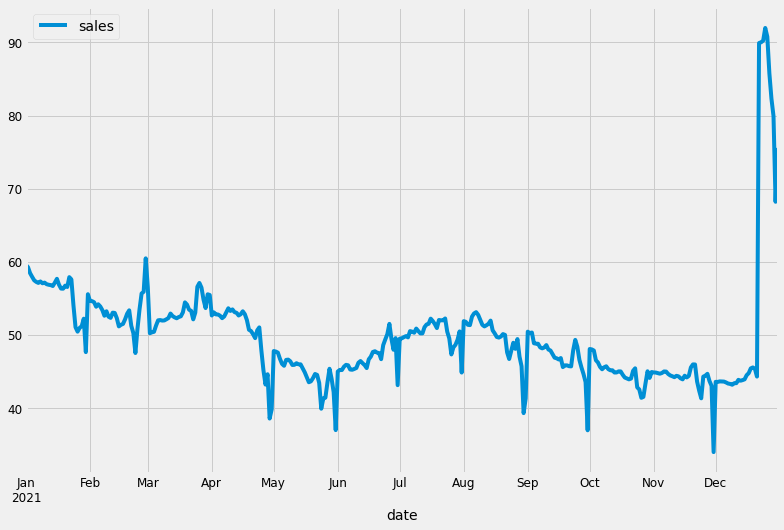

In [4]:
df.columns = ['sales']
df.plot(figsize=(12,8))

## Data Preprocessing and EDA

### To be sure if the data is stationary or not, we run a fixed statistical test 

In [5]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller


In [6]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)


In [7]:
adfuller_test(df['sales'])


1. ADF :  -3.489074223216023
2. P-Value :  0.008272164971273954
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


### since  p < 0.05 ; Data is stationary

In [8]:
import statsmodels.api as sm

### using Auto Correlation Function to measure direct and indirect effects of values in previous time lags

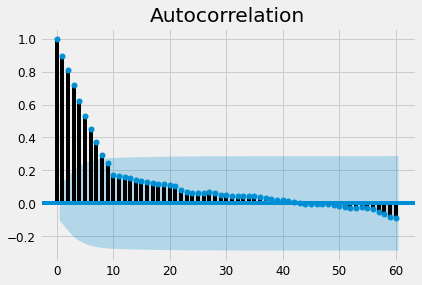

In [9]:
sm.graphics.tsa.plot_acf(df['sales'].values.squeeze(), lags=60)
plt.show()

### we can see the direct previous lag(sales) has the greatest influence(correlation ) to current sales followed by the rest in decreasing order, but for our model we would use the last three sales, because the have the highest correlation 

In [10]:
# df = df.sort_values('creation_date')

In [11]:
# checking for null data
df.isnull().sum()

sales    0
dtype: int64

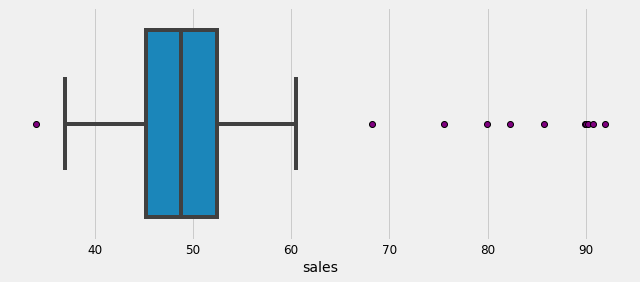

In [12]:
# using boxplot to check for skewness and outliers
plt.figure(figsize=(10,4))

flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=df.sales, flierprops=flierprops)

In [13]:
# shifting backwards to create columns for last 3 months sales as inputs
df['Last_Month_Sales']=df['sales'].shift(+1)
df['Last_2_Month_Sales']=df['sales'].shift(+2)
df['Last_3_Month_Sales']=df['sales'].shift(+3)
df.head(5)

,sales,Last_Month_Sales,Last_2_Month_Sales,Last_3_Month_Sales
date,,,,
2021-01-01,59.580427,NaN,NaN,NaN
2021-01-02,59.264120,59.580427,NaN,NaN
2021-01-03,58.456661,59.264120,59.580427,NaN
2021-01-04,57.947740,58.456661,59.264120,59.580427
2021-01-05,57.471018,57.947740,58.456661,59.264120


In [14]:
# dropping NAN values as a result of shifts
df=df.dropna()
df

,sales,Last_Month_Sales,Last_2_Month_Sales,Last_3_Month_Sales
date,,,,
2021-01-04,57.947740,58.456661,59.264120,59.580427
2021-01-05,57.471018,57.947740,58.456661,59.264120
2021-01-06,57.258093,57.471018,57.947740,58.456661
2021-01-07,57.119050,57.258093,57.471018,57.947740
2021-01-08,57.322077,57.119050,57.258093,57.471018
...,...,...,...,...
2021-12-27,85.779445,90.775527,91.970091,90.236845
2021-12-28,82.313791,85.779445,90.775527,91.970091
2021-12-29,79.929664,82.313791,85.779445,90.775527


# Modelling

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
lm=LinearRegression()
rf=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [16]:
## splitting our datasets to train and test
import numpy as np
x1,x2,x3,y=df['Last_Month_Sales'],df['Last_2_Month_Sales'],df['Last_3_Month_Sales'],df['sales']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)

X_train,X_test,y_train,y_test=final_x[:-30],final_x[-30:],y[:-30],y[-30:]


In [18]:
# training models
lm.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestRegressor(max_features=3, random_state=1)

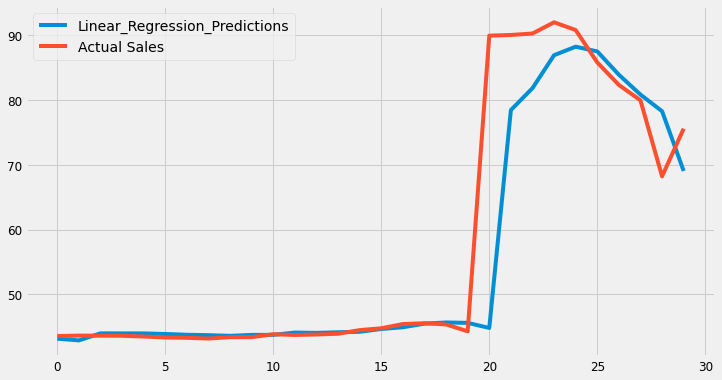

In [19]:
# checking performance of the  LinearRegression Model
lin_pred=lm.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

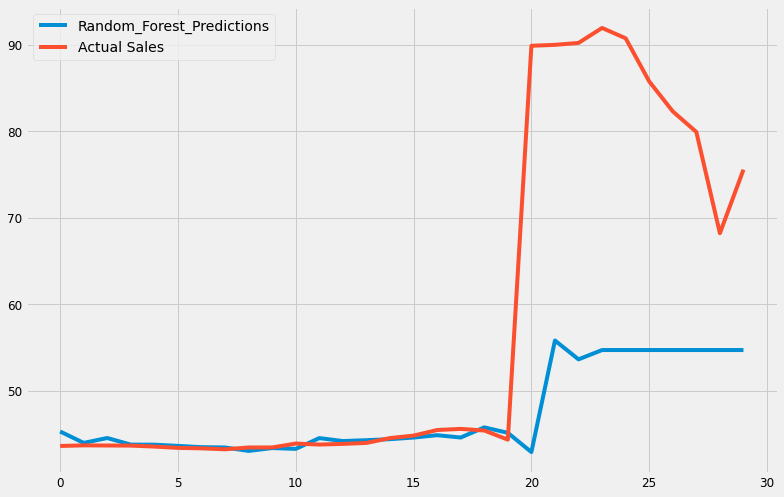

In [20]:
# checking performance of the  RandomForestRegressor Model
pred=rf.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y_test))
rmse_lr=sqrt(mean_squared_error(lin_pred,y_test))

In [22]:
print('Mean Squared Error for Random Forest Model is:',rmse_rf)
print('Mean Squared Error for Linear Regression Model is:',rmse_lr)

Mean Squared Error for Random Forest Model is: 18.625739637069557
Mean Squared Error for Linear Regression Model is: 8.986962300858217


In [23]:
# The Linear Regression Model Trains better